In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
phone_df = pd.read_pickle(PHONBANK_DFS/'phone_df.pickle')

In [5]:
phone_df['n_phones'] = [len(list(flatten(i))) for i in phone_df.phones.values]

In [6]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [7]:
phone_df.dataset.unique()

array(['Providence', 'Davis', 'Goad'], dtype=object)

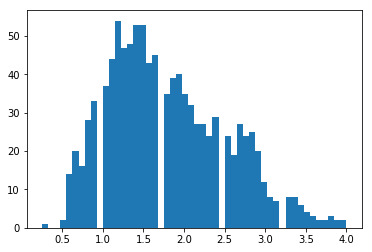

In [8]:
plt.hist(phone_df.age.values, bins = 50);

In [10]:
print("There are {} phones in this dataset".format(np.sum(phone_df.n_phones)))

There are 618583 phones in this dataset


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


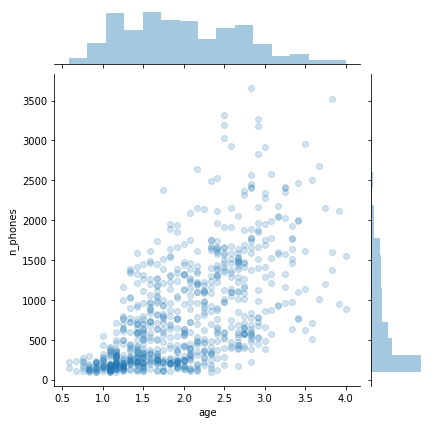

In [11]:
import seaborn as sns
sns.jointplot("age", "n_phones", data=phone_df[phone_df.n_phones > 100], alpha=0.2)

In [12]:
import seaborn as sns
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig
ensure_dir(FIGURE_DIR/ 'distributions')

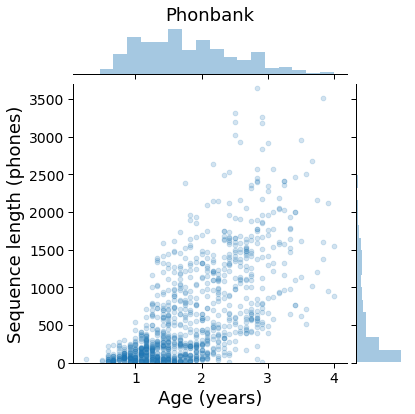

In [13]:
sns.set_context("paper", rc={"font.size":24,"axes.titlesize":18,"axes.labelsize":18, "axes.ticksize":14})   

p = sns.jointplot("age", "n_phones", data=phone_df, alpha=0.2, annot_kws={"size": 16})

p.set_axis_labels(xlabel="Age (years)", ylabel="Sequence length (phones)")
p.ax_joint.tick_params(labelsize=14)
p.ax_marg_x.set_title("Phonbank")
p.ax_joint.set_ylim([0,3700])
save_fig(FIGURE_DIR/ 'distributions' / 'phonbank_distribution')
plt.show()

In [14]:
p.ax_joint

In [15]:
np.median(phone_df.n_phones)

306.0

## MI
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

In [16]:
from childes_mi.information_theory import mutual_information as mi

In [17]:
distances = np.arange(1,101)

#### Run MI by age cohort

In [18]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [19]:
age_cohorts = [[0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [20]:
### sequence length by cohort

In [21]:
def concat(arr):
    """ingore concatenation of zero length list"""
    if len(arr) ==0:
        return []
    else:
        return np.concatenate(arr)

In [22]:
def remove_repeats(sequence):
    if len(sequence) == 0:
        return sequence
    a = np.array(sequence[1:])
    b = np.array(sequence[:-1])
    c = [sequence[0]] + list(a[a != b])
    return c

In [23]:
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    
    median_n_phones = np.median(cohort_subset.n_phones.values)
    print(age_cohort_low, age_cohort_high, median_n_phones)

0.5 1 69.5
1 1.5 189.0
1.5 2 276.0
2 2.5 879.0
2.5 3 1150.0
3 20 1574.0



In [ ]:
mi_df = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_phones",
        "n_unique_phones",
        'shuffling'
    ]
)
    # for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    
    median_n_phones = int(np.median(cohort_subset.n_phones.values))
    
    ### make list of phones
    cohort_phones_list = [
        [
          i for i in "".join(flatten([i for i in flatten(row.phones) if i is not None]))
        ]
        for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list:', [' '.join(i) for i in cohort_phones_list][0][:100])
    
    cohort_phones_list_no_repeats = [
        remove_repeats([
          i for i in "".join(flatten([i for i in flatten(row.phones) if i is not None]))
        ])
        for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list (no repeats):', [' '.join(i) for i in cohort_phones_list_no_repeats][0][:100])

    ### make list of phones shuffled within words
    cohort_phones_list_shuffled_within_words = [
            list(concat([np.random.permutation(list(i)) for i in flatten(row.phones) if i is not None]))
            for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list (shuffled within word):', [' '.join(i) for i in cohort_phones_list_shuffled_within_words][0][:100])

    ### make list of phones shuffled between words
    cohort_phones_list_shuffled_between_words = [
            list(''.join(list(np.random.permutation([i for i in flatten(row.phones) if i is not None]))))
            for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list (shuffled between word):', [' '.join(i) for i in cohort_phones_list_shuffled_between_words][0][:100])

    cohort_phones_list_shuffled_within_utterance = [list(np.concatenate([np.random.permutation(list(''.join(list(flatten([i for i in sent if i is not None]))))) for sent in  trans]))
     for trans in cohort_subset.phones.values]
    print('phones list (shuffled within utterances):', [' '.join(i) for i in cohort_phones_list_shuffled_within_utterance][0][:100])

    # get number of unique elements
    n_phones = len(np.concatenate(cohort_phones_list))
    n_unique_phones = 0 #len(np.unique(np.concatenate(cohort_phones)))
    
    
    distances = np.arange(1, np.max([100, median_n_phones]) + 1)
    
    # make each phone symbol specific to the transcript
    for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows()):
        cohort_phones_list[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list[transcript_i]]
        cohort_phones_list_shuffled_between_words[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_between_words[transcript_i]]
        cohort_phones_list_shuffled_between_words[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_between_words[transcript_i]]
        cohort_phones_list_shuffled_within_utterance[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_within_utterance[transcript_i]]
        cohort_phones_list_no_repeats[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_no_repeats[transcript_i]]

    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list, distances=distances, n_jobs=-1, estimate= False, normalize=True
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'full'
    ]
    
    """(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_within_words, distances=distances, n_jobs=-1, estimate= False
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'shuffled_within_words'
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_between_words, distances=distances, n_jobs=-1, estimate= False
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'shuffled_between_words'
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_within_utterance, distances=distances, n_jobs=-1, estimate= False
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'shuffled_within_utterance'
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_no_repeats, distances=distances, n_jobs=-1, estimate= False
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'no_repeats'
    ]"""
    
    for shuff in ['full']:#, 'shuffled_between_words', 'shuffled_within_words', 'shuffled_within_utterance', 'no_repeats']:
        row = mi_df[mi_df.shuffling == shuff][-1:].iloc[0]
        fig, axs = plt.subplots(ncols=2, figsize=(15,4))
        axs[0].loglog(distances, row.MI - row.shuff_MI)
        axs[0].set_title(shuff)
        axs[1].plot(distances, row.MI)
        axs[1].plot(distances, row.shuff_MI)
        axs[1].set_title(shuff)
        plt.show()
        
    

phones list: ˈ n a ɪ ʌ ˈ j ɪ ɪ m ˈ b ʌ ə m ˈ b ʌ ˈ d ɛ ˈ ɑ ˈ b ɛ ˈ m i ˈ b ɪ ˈ ʌ ɛ ˈ t a ɪ ˈ ɡ ɪ ˈ ɡ a ɪ ˈ d ʌ ˈ 
phones list (no repeats): ˈ n a ɪ ʌ ˈ j ɪ m ˈ b ʌ ə m ˈ b ʌ ˈ d ɛ ˈ ɑ ˈ b ɛ ˈ m i ˈ b ɪ ˈ ʌ ɛ ˈ t a ɪ ˈ ɡ ɪ ˈ ɡ a ɪ ˈ d ʌ ˈ m 
phones list (shuffled within word): ɪ ˈ a n j ˈ ɪ ʌ ˈ m ɪ b ʌ ʌ m ə b ˈ ˈ ɛ d ɑ ˈ ˈ b ɛ i ˈ m ˈ ɪ b ˈ ʌ ɪ a ɛ ˈ t ˈ ɡ ɪ ɪ ɡ ˈ a d ʌ ˈ u 
phones list (shuffled between word): ˈ ʌ ʔ ˈ k i u ɪ m ˈ b ʌ ˈ h ɛ ˈ b ɪ ˈ b ʊ b ʊ ˈ b ɪ m ə ˈ b u ˈ ɑ ː m ˈ m ʌ ˈ ɡ ɪ ˈ m j ɛ ˈ ɡ e ɪ ˈ 
phones list (shuffled within utterances): ˈ a ɪ n ɪ ʌ j ˈ ɪ b ˈ m ʌ ˈ ə b m ʌ ˈ d ɛ ˈ ɑ ˈ ɛ b ˈ m i ˈ b ɪ ˈ ʌ a ˈ ɛ ɪ t ɡ ˈ ɪ ɡ a ˈ ɪ d ʌ ˈ u 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


In [ ]:
#mi_df.to_pickle(DATA_DIR / "mi" / "phonbank_mi_with_shuffling_median.pickle")

full


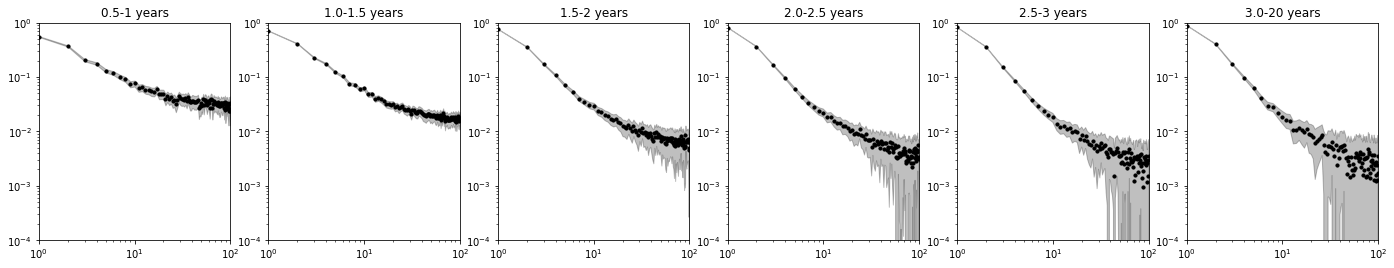

shuffled_between_words


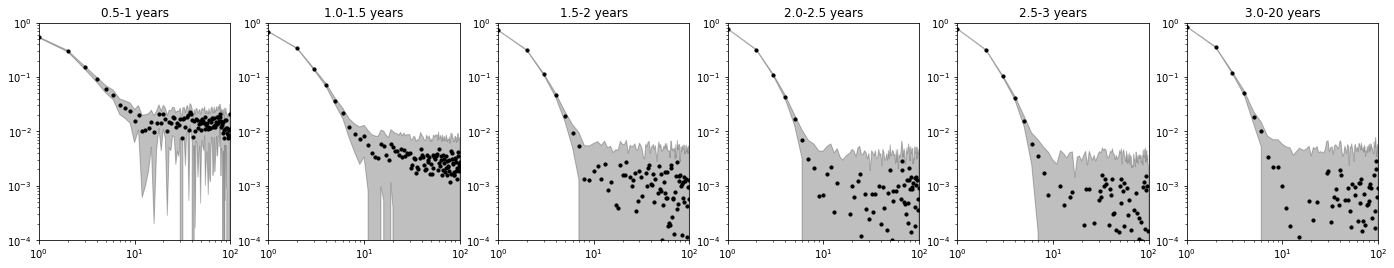

shuffled_within_words


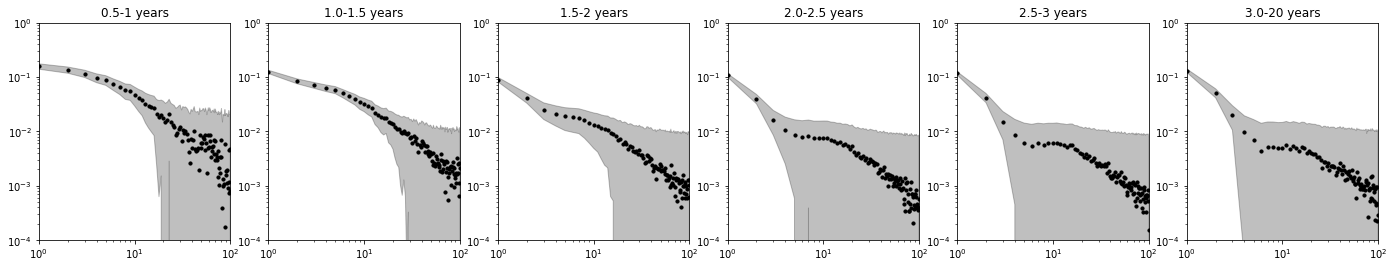

shuffled_within_sentence


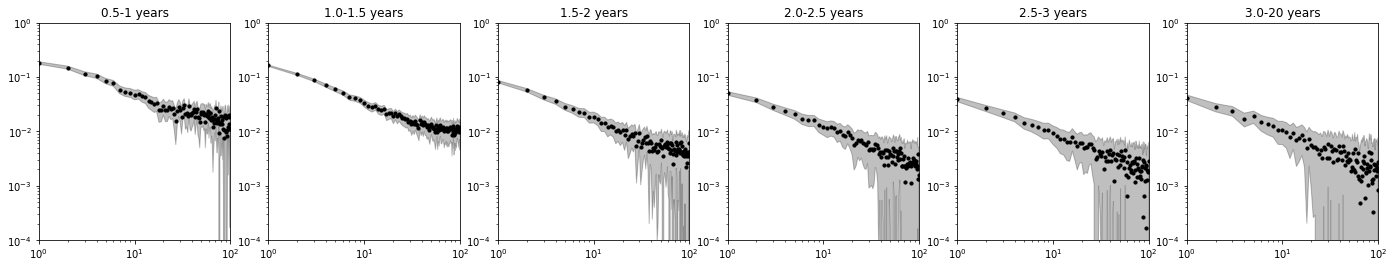

no_repeats


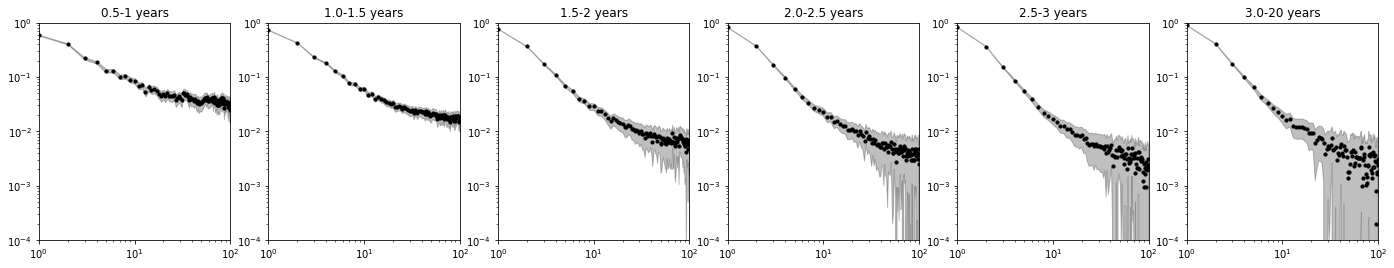

In [26]:
for shuff in ['full', 'shuffled_between_words', 'shuffled_within_words', 'shuffled_within_utterance', 'no_repeats']:
    print(shuff)
    fig, axs = plt.subplots(ncols=len(age_cohorts), figsize=(4*len(age_cohorts),4))

    for axi, (idx, row) in enumerate(mi_df.iterrows()):
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax = axs[np.array([i[0] for i in age_cohorts]) == row.age_cohort_low][0]
        #ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.scatter(distances, row.MI-row.shuff_MI, s=10, color='k')
        ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
        #ax.legend()
        ax.set_title('{}-{} years'.format(row.age_cohort_low, row.age_cohort_high))
        ax.set_ylim([1e-4,1])
        ax.set_xlim([1, 100])

        ax.set_yscale('log')
        ax.set_xscale('log')
    plt.show()

In [29]:
mi_df

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,shuffling
0,"[-13027.425640231451, -16426.425637892535, -17...","[151.20569536895175, 148.565909057372, 148.450...","[-19570.425812613754, -19564.42581851582, -194...","[148.440947573449, 148.31823802359014, 148.190...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,60390,0,full
1,"[-2220.5561544640577, -2233.556216455724, -227...","[141.22727001100435, 140.89271266290638, 140.9...","[-2291.5574656830486, -2332.5573489438143, -22...","[141.20106672277873, 141.6796972727442, 140.62...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,60390,0,shuffled_within_words
2,"[-13175.425649919951, -16872.425687234623, -18...","[151.2810873776387, 148.66713712965964, 148.28...","[-19583.425812926413, -19560.425817952797, -19...","[148.55913303720055, 148.35894583632245, 148.1...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,60390,0,shuffled_between_words
3,"[-17509.425764852393, -18045.425778273122, -18...","[148.93308690043585, 148.45418145367492, 148.1...","[-19601.42581131251, -19567.425818931457, -194...","[148.27962855837674, 148.31090655835177, 147.7...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,60390,0,shuffled_within_utterance
4,"[-12487.425651161491, -16089.425644841012, -17...","[149.1434605948167, 146.2152816675982, 146.142...","[-19397.425835019614, -19337.42584202552, -192...","[146.096356151564, 146.13329183399244, 145.840...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,60390,0,no_repeats
5,"[-45271.42462949534, -60378.42465697197, -6720...","[334.9091266918384, 331.09129098359404, 329.95...","[-75339.42471283242, -75087.42471459962, -7490...","[328.77913051465885, 328.8726159518871, 328.51...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.5,312914,0,full
6,"[-2858.556311523693, -2959.556269289371, -3002...","[243.07589373360236, 244.27532533985809, 244.4...","[-3009.556301669725, -3030.556308409295, -3028...","[239.9589971030636, 239.726703984041, 248.6546...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.5,312914,0,shuffled_within_words
7,"[-46649.424633206225, -62937.42466705976, -699...","[334.67546689649294, 330.7683141745446, 329.16...","[-75261.42471259902, -75116.4247149473, -75042...","[328.9444526844377, 328.4730132462925, 328.200...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.5,312914,0,shuffled_between_words
8,"[-67770.42470565812, -70388.42470962011, -7166...","[330.2712314397959, 329.65496244531164, 328.99...","[-75205.42471298113, -75314.42471448038, -7509...","[328.74943981810844, 328.5733436612239, 328.50...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.5,312914,0,shuffled_within_utterance
9,"[-43914.42466372675, -59574.42469140238, -6648...","[332.4838390468008, 328.46574774583746, 327.35...","[-74696.42474910743, -74699.42475074984, -7468...","[326.2621352084862, 325.805790816277, 325.8450...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.5,312914,0,no_repeats


full


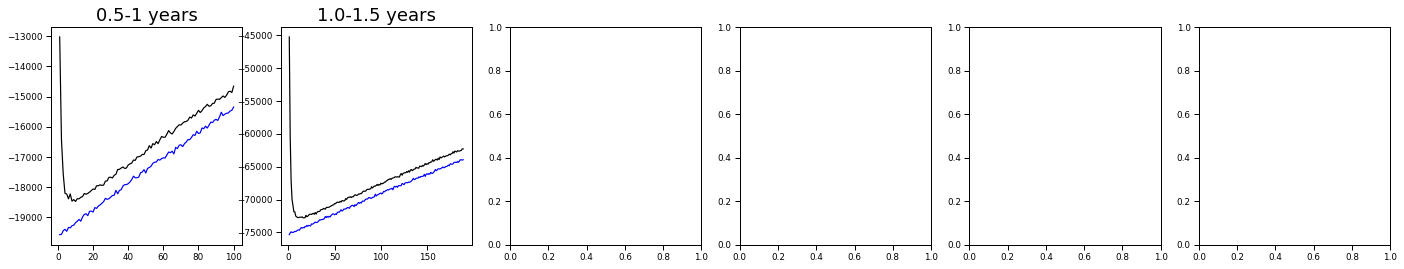

shuffled_between_words


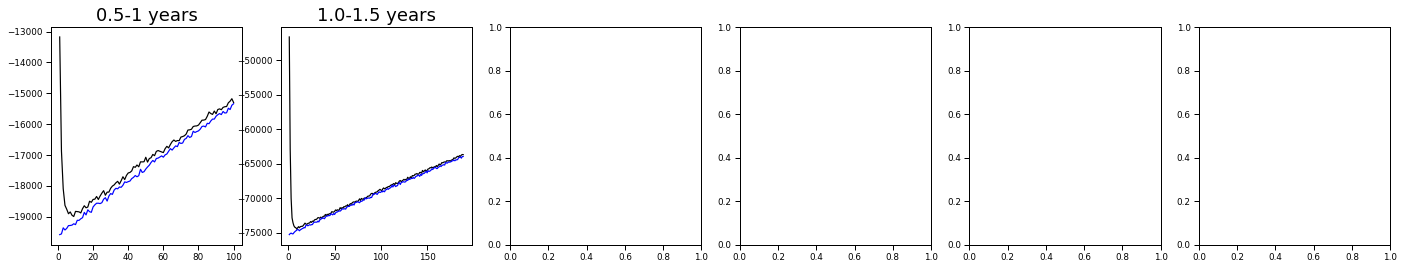

shuffled_within_words


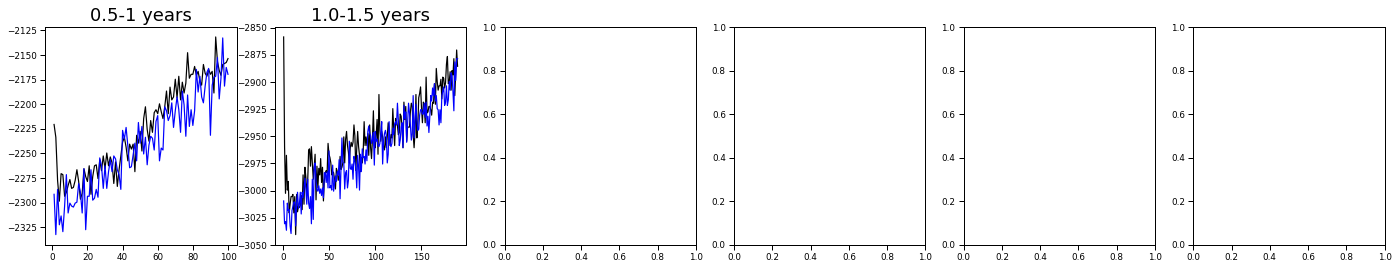

shuffled_within_utterance


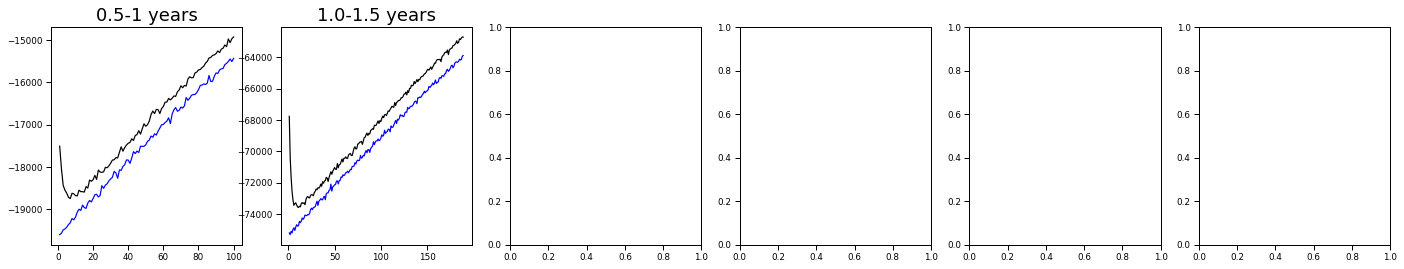

no_repeats


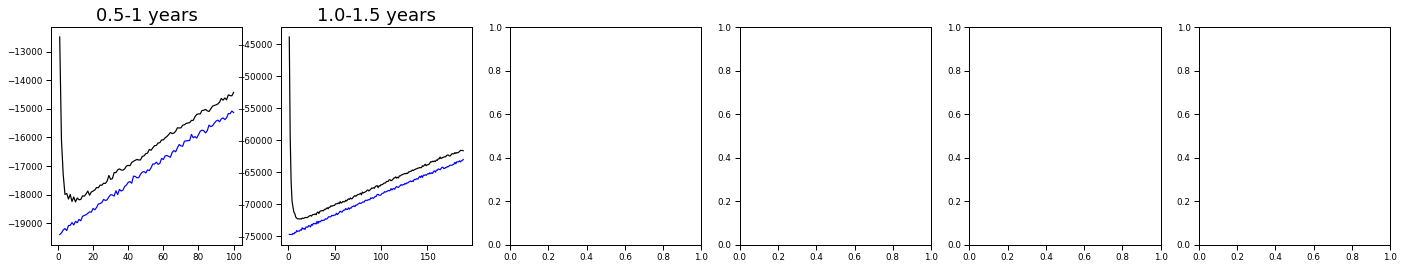

In [30]:
for shuff in ['full', 'shuffled_between_words', 'shuffled_within_words', 'shuffled_within_utterance', 'no_repeats']:
    print(shuff)
    fig, axs = plt.subplots(ncols=len(age_cohorts), figsize=(4*len(age_cohorts),4))

    for axi, (idx, row) in enumerate(mi_df.iterrows()):
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax = axs[np.array([i[0] for i in age_cohorts]) == row.age_cohort_low][0]
        #ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.plot(row.distances, row.MI, color='k')
        ax.plot(row.distances, row.shuff_MI, color='b')
        #ax.fill_between(row.distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
        #ax.legend()
        ax.set_title('{}-{} years'.format(row.age_cohort_low, row.age_cohort_high))
        #ax.set_ylim([1e-4,1])
        #ax.set_xlim([1, 100])

        #ax.set_yscale('log')
        #ax.set_xscale('log')
    plt.show()